<a href="https://colab.research.google.com/github/ahmadrathore/Provisioning-SmartX-MicroBox/blob/master/Bidirectional_LSTM_Multivariate_Horizon_Style_Flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [377]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [378]:
#df = pd.read_csv(r'merge-csv.com__602f0aa73c265.csv')
#df = pd.read_csv('merge-csv.com__602f0aa73c265.csv',index_col='Processing_time',
 #               infer_datetime_format=True)
#url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/Network-Flows.csv'
url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows.csv'

df = pd.read_csv(url,index_col='Processing_time',
                infer_datetime_format=True)



#df = pd.read_csv(url,index_col='Processing_time',
#               # infer_datetime_format=True)
#                parse_dates=True)

In [379]:
df.head()

,Measurement_boxname,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
Processing_time,,,,,,,,,,,,,,,
2020-12-01T00:05:24.998+09:00,smartx-microbox-gist-1,39846,9092,6,183,2438,2439,2439,0.07,161,11888,2788.26,2591.23,510252,170.018
2020-12-01T00:10:44.861+09:00,smartx-microbox-gist-1,39846,9092,6,396,2438,2439,2439,0.11,63,11856,2228.37,2094.46,882435,290.016
2020-12-01T00:15:33.979+09:00,smartx-microbox-gist-1,39846,9092,6,395,2438,2439,2439,0.13,102,13084,2209.62,2321.09,872801,290.017
2020-12-01T00:25:41.464+09:00,smartx-microbox-gist-1,39846,9092,6,459,2438,2439,2439,0.09,61,11550,1989.66,1919.81,913254,290.017
2020-12-01T00:35:18.114+09:00,smartx-microbox-gist-1,39846,9092,6,456,2438,2439,2439,0.09,87,11544,1981.21,1909.48,903430,290.011


In [380]:
df.describe()

,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
count,8576.000000,8576.0,8576.0,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,40807.862873,9092.0,6.0,362.090602,2315.889576,2317.284632,2316.846782,0.317004,76.953708,10271.796525,2104.136580,2048.747845,761531.681087,279.171818
std,3907.567979,0.0,0.0,56.159077,395.897535,394.644232,395.614646,1.226467,19.597907,1867.873236,175.951136,231.740512,131589.840309,34.988489
min,33560.000000,9092.0,6.0,22.000000,499.000000,501.000000,501.000000,0.000000,59.000000,5971.000000,1387.150000,1291.840000,44072.000000,10.014000
25%,39846.000000,9092.0,6.0,340.000000,2438.000000,2439.000000,2439.000000,0.000000,62.000000,8740.000000,1973.480000,1867.347500,686703.750000,290.015000
50%,39846.000000,9092.0,6.0,369.000000,2438.000000,2439.000000,2439.000000,0.050000,69.000000,10587.000000,2094.890000,2032.635000,709585.000000,290.016000
75%,40442.000000,9092.0,6.0,398.000000,2439.000000,2439.000000,2439.000000,0.100000,88.000000,11718.000000,2226.530000,2229.402500,882164.750000,290.017000
max,59584.000000,9092.0,6.0,514.000000,2439.000000,2439.000000,2439.000000,21.950000,264.000000,14764.000000,2899.900000,2856.150000,923288.000000,290.056000


In [381]:
#df.drop_duplicates(subset=['Processing_time'], keep=False,inplace=True)

In [382]:
Measurement_boxname_le = preprocessing.LabelEncoder()
df['Measurement_boxname_le'] = Measurement_boxname_le.fit_transform(df['Measurement_boxname']) 

In [383]:
df = df[['min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']]

In [384]:
validate = df[['min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(50)
df.drop(df.tail(50).index,inplace=True)

In [385]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [386]:
validate = df[['min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(50)
df.drop(df.tail(50).index,inplace=True)

In [387]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(df[['Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']])
dataY = y_scaler.fit_transform(df[['avg_databytes']])

In [388]:
"""
#hist_window = 48
#horizon = 10
hist_window =35
#horizon = 30
horizon = 10
"""
hist_window =80
horizon = 50


TRAIN_SPLIT = 5500
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi = custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [389]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.         0.49756098 0.67292164 0.92620063 0.83064738 0.53022238]
 [0.         0.0195122  0.66928238 0.5560866  0.51308245 0.95353474]
 [0.         0.2097561  0.80893893 0.54369195 0.65795782 0.94257725]
 ...
 [0.         0.10243902 0.67007847 0.47717072 0.52669867 0.96932836]
 [0.         0.0097561  0.68452178 0.43229218 0.53031049 0.96204801]
 [0.         0.1804878  0.69487092 0.49355148 0.54001445 0.95218581]]

 Target horizon
[[0.41750454]
 [0.47595439]
 [0.54192695]
 [0.57316146]
 [0.65403404]
 [0.48552636]
 [0.69049744]
 [0.38921831]
 [0.53079491]
 [0.39982152]
 [0.82141134]
 [0.60527516]
 [0.64546686]
 [0.65524376]
 [0.51282102]
 [0.55172368]
 [0.51281441]
 [0.60160635]
 [0.47832755]
 [0.55473145]
 [0.78102793]
 [0.5663725 ]
 [0.61737895]
 [0.68243266]
 [0.56417121]
 [0.49289043]
 [0.5290233 ]
 [0.50515948]
 [0.608078  ]
 [0.58781689]
 [0.63149232]
 [0.48335812]
 [0.40724508]
 [0.49710792]
 [0.49233515]
 [0.54100149]
 [0.71851925]
 [0.6267526 ]
 

In [390]:
#BATCH_SIZE = 256
#BUFFER_SIZE = 150
#BATCH_SIZE = 64
#BUFFER_SIZE = 37
#BATCH_SIZE = 150
BATCH_SIZE = 64
BUFFER_SIZE = 100

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [391]:
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True), 
                               input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')


In [392]:
model_path = r'Bidirectional_LSTM_Multivariate.h5'

In [393]:
#EVALUATION_INTERVAL = 100
#EPOCHS = 150
#EVALUATION_INTERVAL = 70
EVALUATION_INTERVAL = 50
#EPOCHS = 150
EPOCHS = 50
#history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose=1,
history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=30, verbose=1,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'), tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/50
50/50 [==============================] - 8s 73ms/step - loss: 0.1881 - val_loss: 0.0160
Epoch 2/50
50/50 [==============================] - 2s 49ms/step - loss: 0.0475 - val_loss: 0.0072
Epoch 3/50
50/50 [==============================] - 2s 49ms/step - loss: 0.0311 - val_loss: 0.0064
Epoch 4/50
50/50 [==============================] - 2s 50ms/step - loss: 0.0192 - val_loss: 0.0153
Epoch 5/50
50/50 [==============================] - 2s 49ms/step - loss: 0.0212 - val_loss: 0.0073
Epoch 6/50
50/50 [==============================] - 2s 50ms/step - loss: 0.0210 - val_loss: 0.0233
Epoch 7/50
50/50 [==============================] - 2s 50ms/step - loss: 0.0190 - val_loss: 0.0160
Epoch 8/50
50/50 [==============================] - 2s 49ms/step - loss: 0.0170 - val_loss: 0.0076
Epoch 9/50
50/50 [==============================] - 2s 49ms/step - loss: 0.0153 - val_loss: 0.0226
Epoch 10/50
50/50 [==============================] - 2s 50ms/step - loss: 0.0156 - val_loss: 0.0073
Epoch 11/

In [394]:
Trained_model = tf.keras.models.load_model(model_path)

In [395]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_26 (Bidirectio (None, 200, 300)          188400    
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 100)               140400    
_________________________________________________________________
dense_26 (Dense)             (None, 20)                2020      
_________________________________________________________________
dropout_13 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 50)                1050      
Total params: 331,870
Trainable params: 331,870
Non-trainable params: 0
_________________________________________________________________


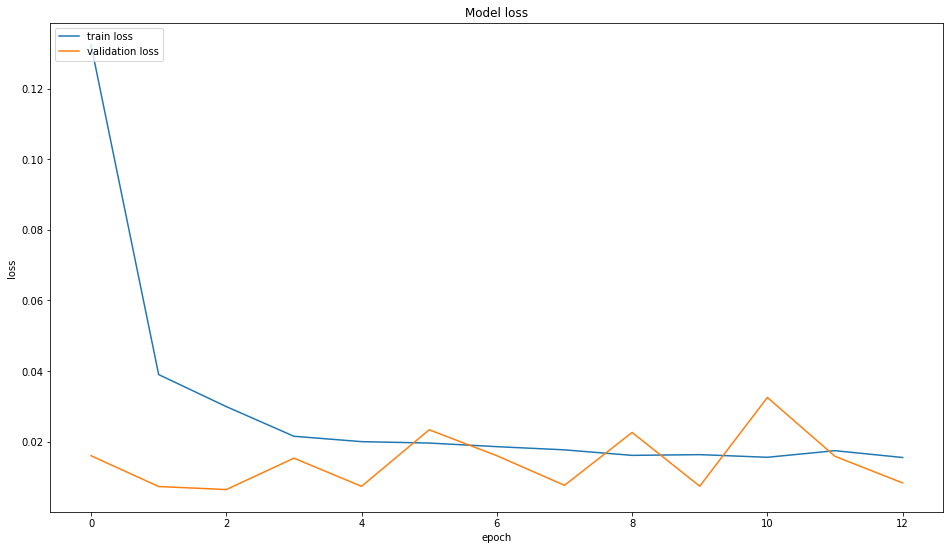

In [396]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [397]:
data_val = x_scaler.fit_transform(df[['Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']].tail(50))

In [398]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [399]:
Predicted_results = Trained_model.predict(val_rescaled)

In [400]:
Predicted_results

array([[0.41643885, 0.42085254, 0.41816488, 0.41885307, 0.41350853,
        0.38017926, 0.43102658, 0.40624037, 0.43652484, 0.4377773 ,
        0.4235348 , 0.44633737, 0.39681727, 0.420453  , 0.41470066,
        0.40184262, 0.4585801 , 0.41351715, 0.4124909 , 0.42260352,
        0.4361402 , 0.41196078, 0.42245895, 0.42307228, 0.44268373,
        0.4382733 , 0.38305095, 0.38308704, 0.40093818, 0.38456887,
        0.38488   , 0.39844224, 0.39087516, 0.4179633 , 0.419481  ,
        0.41342607, 0.4215803 , 0.38824758, 0.40626833, 0.34884474,
        0.39441308, 0.36510938, 0.41243836, 0.4228866 , 0.4061948 ,
        0.4219335 , 0.44671488, 0.40555298, 0.43048358, 0.39547968]],
      dtype=float32)

In [401]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [402]:
Predicted_results_Inv_trans

array([[2017.1178, 2023.7947, 2019.7289, 2020.7699, 2012.685 , 1962.2662,
        2039.1854, 2001.6901, 2047.5029, 2049.3975, 2027.8524, 2062.347 ,
        1987.4354, 2023.1904, 2014.4884, 1995.0374, 2080.8672, 2012.698 ,
        2011.1458, 2026.4435, 2046.921 , 2010.3438, 2026.2249, 2027.1527,
        2056.8198, 2050.148 , 1966.6102, 1966.6649, 1993.6692, 1968.9066,
        1969.3773, 1989.8936, 1978.4465, 2019.424 , 2021.72  , 2012.5602,
        2024.8956, 1974.4716, 2001.7324, 1914.8649, 1983.7985, 1939.4694,
        2011.0662, 2026.8717, 2001.6212, 2025.4299, 2062.918 , 2000.6503,
        2038.364 , 1985.4119]], dtype=float32)

In [403]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [404]:
timeseries_evaluation_metrics_func(validate['total_data_bytes'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 533440172953.81177
MAE is : 724496.3981640625
RMSE is : 730369.8877649679
MAPE is : 99.71622305817789
R2 is : -61.43218756637814



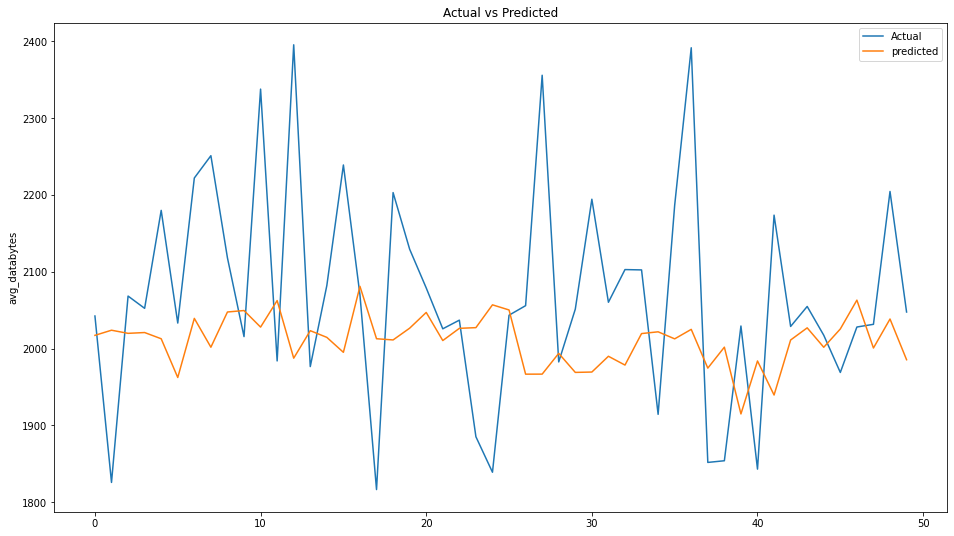

In [405]:
plt.plot( list(validate['avg_databytes']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("avg_databytes")
plt.legend(('Actual','predicted'))
plt.show()